In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
from tqdm import tqdm
import concurrent.futures

print(os.listdir())
import matplotlib.pyplot as plt

['social.txt', 'social_A.txt', 'youtube.ipynb', 'social_graph_indicator.txt', 'shaded.png', 'sampling_test.ipynb', 'social_to_adjacency.ipynb', '.ipynb_checkpoints', 'social_node_labels.txt', 'twitch.ipynb', 'social_graph_labels.txt', 'musae_facebook_edges.csv', 'Figures', 'social_to_ds.ipynb', 'large_twitch_edges.csv', '.DS_Store', 'artist_edges.csv']


In [2]:
parent_directory = os.path.dirname(os.getcwd())
data_directory   = os.path.join(parent_directory, "raw_datasets/facebook_large")

In [3]:
filename = "musae_facebook_edges.csv"
dataset_path = os.path.join(data_directory, filename)

social_data = pd.read_csv(dataset_path, delimiter = ",", skiprows = 0)
print(social_data.shape)
# np.savetxt(r'social_A.txt', social_data.values, fmt='%d', delimiter=",\t")
social_data.head()

(171002, 2)


,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [4]:
target_filename = "musae_facebook_target.csv"
target_path     = os.path.join(data_directory, target_filename)

target_data = pd.read_csv(target_path, delimiter = ",", skiprows = 0)
target_data.head()

node_ids = target_data["id"].tolist()
page_types = target_data["page_type"].tolist()


classes = np.unique(page_types)
int_labels = [i for i in range(classes.shape[0])]

conv_dict = {}
for i, page_type in enumerate(list(classes)):
    conv_dict[page_type] = int_labels[i]
    
print(conv_dict)

int_labels = {}

for i, item in enumerate(page_types):
    int_labels[str(i)] = conv_dict[item]

{'company': 0, 'government': 1, 'politician': 2, 'tvshow': 3}


In [5]:
import json

attribute_filename = "musae_facebook_features.json"
attribute_path     = os.path.join(data_directory, attribute_filename)

with open(attribute_path, "r") as f:
    attribute_data = json.load(f)
    
attribute_shape = len(attribute_data["15"])

keys = list(attribute_data.keys())
lengths = [len(attribute_data[l]) for l in keys]
tokens = []
for k in keys:
    tokens += attribute_data[k]
print(np.unique(lengths))
print(np.min(tokens))
print(np.max(tokens))

def feature_to_token(feature, min_t = 0, max_t = 4800):
    out_vector = np.zeros(max_t)
    out_vector[feature] = 1
    return out_vector

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 19 20 21 22 23 24 25 26 27 28 29
 30 31]
0
4713


/home/alex/anaconda3/envs/pytorch_graphs/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(22470, 4800)
UMAP(n_components=20, n_jobs=6, n_neighbors=100, verbose=1)
Wed Jul  6 09:50:28 2022 Construct fuzzy simplicial set
Wed Jul  6 09:50:29 2022 Finding Nearest Neighbors
Wed Jul  6 09:50:29 2022 Building RP forest with 12 trees
Wed Jul  6 09:50:30 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Wed Jul  6 09:51:03 2022 Finished Nearest Neighbor Search
Wed Jul  6 09:51:05 2022 Construct embedding


Epochs completed: 100%| ██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ 200/200 [00:11]


Wed Jul  6 09:51:19 2022 Finished embedding


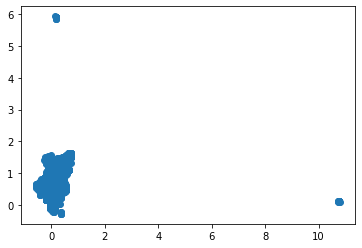

In [6]:
from umap import UMAP
embedder = UMAP(n_components = 20, n_neighbors = 100, n_jobs = 6, verbose = 1)

X = np.array([feature_to_token(attribute_data[k]) for k in keys])
print(X.shape)

features = embedder.fit_transform(X)

plt.scatter(features[:,0], features[:,1])
plt.show()

In [7]:
# G = nx.Graph()
# for i in tqdm(range(social_data.shape[0])):
#     G.add_edge(social_data.iloc[i, 0], social_data.iloc[i,1])
# edgelist = [(social_data.iloc[i,0], social_data.iloc[i,1]) for i in tqdm(range(social_data.shape[0]))]
# print(edgelist)

columns = list(social_data.columns)
print(columns)

G = nx.from_pandas_edgelist(social_data, columns[0], columns[1], create_using = nx.Graph)

for i, node in enumerate(list(G.nodes)):
    
    G.nodes[node]["target"] = int_labels[str(node)]
    G.nodes[node]["attribute"] = features[i,:]
    # print(features[i,:])

['id_1', 'id_2']


In [8]:
G = nx.convert_node_labels_to_integers(G)

(171002, 2)
22470
400
80000


  0%|                                                                                                                                                                                      | 0/200 [00:00<?, ?it/s]

(399, 20)
0.9975


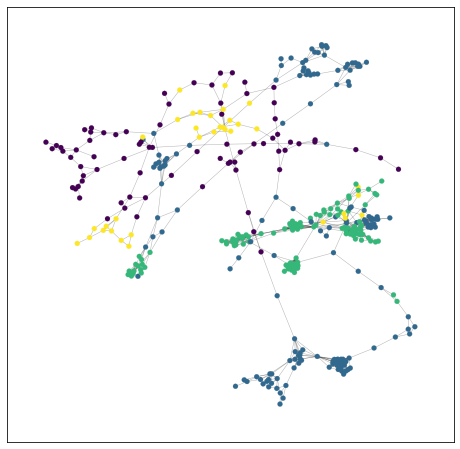

 24%|██████████████████████████████████████████▍                                                                                                                                  | 49/200 [00:01<00:04, 35.89it/s]

(20349, 20)
50.8725


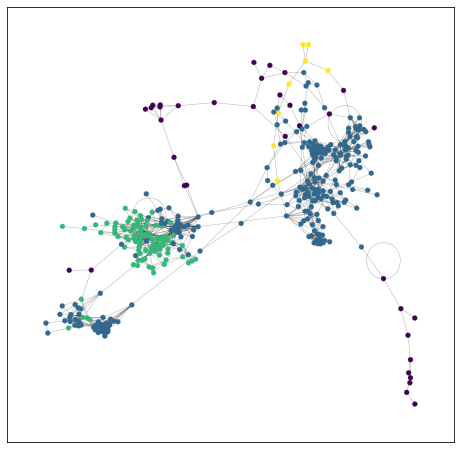

 48%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 97/200 [00:03<00:02, 36.96it/s]

(40299, 20)
100.7475


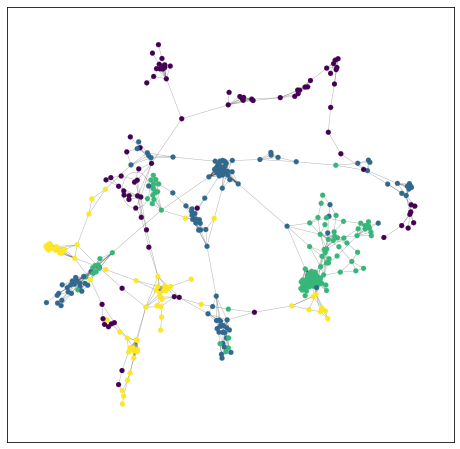

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 150/200 [00:05<00:01, 37.57it/s]

(60249, 20)
150.6225


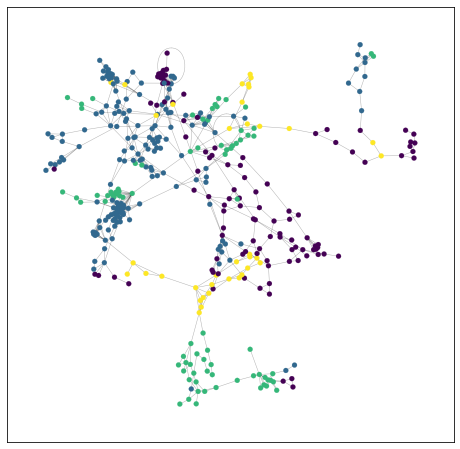

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 27.36it/s]

(249596, 2)
(79800,)


In [112]:
from littleballoffur import ForestFireSampler, MetropolisHastingsRandomWalkSampler, RandomWalkSampler, DiffusionSampler
print(social_data.shape)
n_nodes = np.unique(social_data.values).shape[0]
print(n_nodes)
n_graphs = 200

graph_ind_array = np.zeros(n_nodes)
min_per_graph = 399
n_per_graph = 400#int(n_nodes / n_graphs)

print(n_per_graph)

total_n = n_per_graph * n_graphs



print(total_n)
graph_ind_array = np.zeros(total_n)

graphlist = []
#number_of_nodes = int(0.5*graph.number_of_nodes())

offset_index = 0
for i in tqdm(range(n_graphs)):
    
    
    sampler = MetropolisHastingsRandomWalkSampler(number_of_nodes = np.random.randint(min_per_graph, n_per_graph), #n_per_graph,#
                               seed = np.random.randint(1, 1e9))
    new_graph = sampler.sample(G)
    
    # print(len(list(new_graph.nodes())))
    
    new_graph = nx.convert_node_labels_to_integers(new_graph, first_label=offset_index)
    
    graph_ind_array[offset_index:(i+1) * n_per_graph] = i+1
    
    nodes = list(new_graph.nodes())
    
    node_labels_g = [new_graph.nodes[n]["target"] for n in new_graph.nodes]
    node_attrs_g = [new_graph.nodes[n]["attribute"] for n in new_graph.nodes]
    
    graphlist.append(new_graph)
    
    
    if i ==0:
        graph_adj = np.array(new_graph.edges())
        graph_ind_array = np.array(np.full(len(nodes), i+1))
        node_labels = np.array(node_labels_g)
        node_attrs = np.array(node_attrs_g)
        
    else:
        graph_adj = np.append(graph_adj, np.array(new_graph.edges()), axis = 0)
        graph_ind_array = np.append(graph_ind_array, np.array(np.full(len(nodes), i+1)))
        node_labels = np.append(node_labels, node_labels_g)
        node_attrs = np.append(node_attrs, node_attrs_g, axis = 0)
    
    if i % 50 == 0:
        print(node_attrs.shape)
        print(node_attrs.shape[0]/n_per_graph)
        
        plt.figure(figsize = (8,8))
        
        pos = nx.spring_layout(
          new_graph, k=0.1, iterations=100)
        
        
        colors = []
        
        for g in new_graph.nodes:
            colors.append(new_graph.nodes[g]["target"])
        
        nx.draw_networkx_nodes(
          new_graph,
          pos,
          node_size=25,
          node_color=colors,
          alpha=1,
          linewidths=0.2)#,
          # font_size=1.5)
        nx.draw_networkx_edges(new_graph, pos, alpha=0.3, width=0.5)

        plt.savefig(f"Figures/graph_example{i}.jpg")
        plt.show()
    offset_index += len(nodes)

print(graph_adj.shape)
print(graph_ind_array.shape)

total_n = graph_ind_array.shape[0]

In [10]:
node_attrs.shape

(79800, 20)

In [11]:
data_dir =        "/home/alex/Projects/GRAN_social/data/FACEBOOK_LARGE/"

# for file in os.listdir(data_dir):
#     print(file)
#     if "DUMMY" in file:
#         shutil.rmtree(f"{data_dir}{file}")

np.savetxt(f'{data_dir}FACEBOOK_LARGE_A.txt', graph_adj, fmt='%d', delimiter=",\t")
np.savetxt(f'{data_dir}FACEBOOK_LARGE_graph_indicator.txt',graph_ind_array, fmt="%d")

np.savetxt(f'{data_dir}FACEBOOK_LARGE_node_labels.txt', node_labels, fmt = "%d")
print(node_labels.shape)

np.savetxt(f'{data_dir}FACEBOOK_LARGE_node_attributes.txt', node_attrs, fmt = "%f", delimiter=",")
print(node_labels.shape)

# np.savetxt(f'{data_dir}FACEBOOK_LARGE_node_attributes.txt', node_labels, fmt = "%d")
# print(node_labels.shape)

np.savetxt(f'{data_dir}FACEBOOK_LARGE_graph_labels.txt', np.ones(total_n), fmt = "%d")
print(np.ones(total_n).shape)


        
# np.savetxt(r'social_A.txt', graph_adj, fmt='%d', delimiter=",\t")
# np.savetxt(r'social_graph_indicator.txt',graph_ind_array, fmt="%d")

# np.savetxt(r'social_node_labels.txt', np.arange(1, total_n+1), fmt = "%d")
# print(np.arange(1, total_n+1).shape)

# np.savetxt(r'social_graph_labels.txt', np.ones(total_n), fmt = "%d")
# print(np.ones(total_n).shape)

(79800,)
(79800,)
(79800,)


In [113]:
from scipy.ndimage import gaussian_filter1d


def calculate_probability_by_degree(G, ax = None):
    
    classes = []
    for n in G.nodes:
        if G.nodes[n]["target"] not in classes:
            classes.append(G.nodes[n]["target"])

    degrees = {}
    for item in classes:
        degrees[item] = []

    for n in list(G.nodes()):
        cl = G.nodes[n]["target"]
        deg = G.degree(n)
        degrees[cl].append(deg)

    degree_list = [degrees[d] for d in degrees]
    labels = list(degrees.keys())
    print(labels)
    print(sorted(labels))
    degree_list = [degree_list[l] for l in sorted(labels)]
    

    # plt.hist(degree_list, label = labels, bins = 100, histtype = "step")
    # plt.yscale("log")
    # plt.legend()
    
    max_bin = np.max([np.max(d) for d in degree_list])

    degree_array = np.zeros((max_bin, len(labels)))

    max_bin = np.max([np.max(d) for d in degree_list])
    print(max_bin)

    for i, d in enumerate(degree_list):

        count, bins = np.histogram(d, bins = max_bin, range = (0, max_bin))

        n_degrees = count.shape[0]


        
        degree_array[:, i] = count

    
    for i in range(degree_array.shape[0]):
        sli = degree_array[i,:].tolist()
        if sli == [0,0,0,0]:
            degree_array[i,:] = [1,1,1,1]
        for n, d in enumerate(sli):
            if d == 0:
                degree_array[i, n] = 0.1
        
    
    

    # degree_array = gaussian_filter1d(count, sigma = 15, axis = 0)
    
    # print(degree_array)

    # sum_array = np.sum(degree_array, axis = 1)

    for d in range(degree_array.shape[1]):
        degree_array[:,d] = gaussian_filter1d(degree_array[:,d], sigma = 10)
    
    sum_array = np.sum(degree_array, axis = 1)
    for d in range(degree_array.shape[1]):
        degree_array[:,d] = degree_array[:,d] / sum_array
    
    
    if ax is not None:
        for i in labels:
            ax.fill_between(np.arange(degree_array[:,i].shape[0]), degree_array[:,i],
                            zorder = 100/ np.min(degree_array[:,i]),alpha = 0.25)
            ax.plot(np.arange(degree_array[:,i].shape[0]), degree_array[:,i],
                label = f"{classes[i]}", zorder = 10000)
        ax.legend(shadow = True, loc = "upper left")
        return ax
    
    return degree_array
    
calculate_probability_by_degree(G)

[3, 1, 0, 2]
[0, 1, 2, 3]
709


array([[0.17512602, 0.20927557, 0.36473985, 0.25085855],
       [0.17498277, 0.20973606, 0.36435143, 0.25092974],
       [0.17469581, 0.21065974, 0.36357227, 0.25107218],
       ...,
       [0.21258967, 0.362231  , 0.21258967, 0.21258967],
       [0.21201106, 0.36396683, 0.21201106, 0.21201106],
       [0.21171769, 0.36484694, 0.21171769, 0.21171769]])

[1, 0, 3, 2]
[0, 1, 2, 3]
33


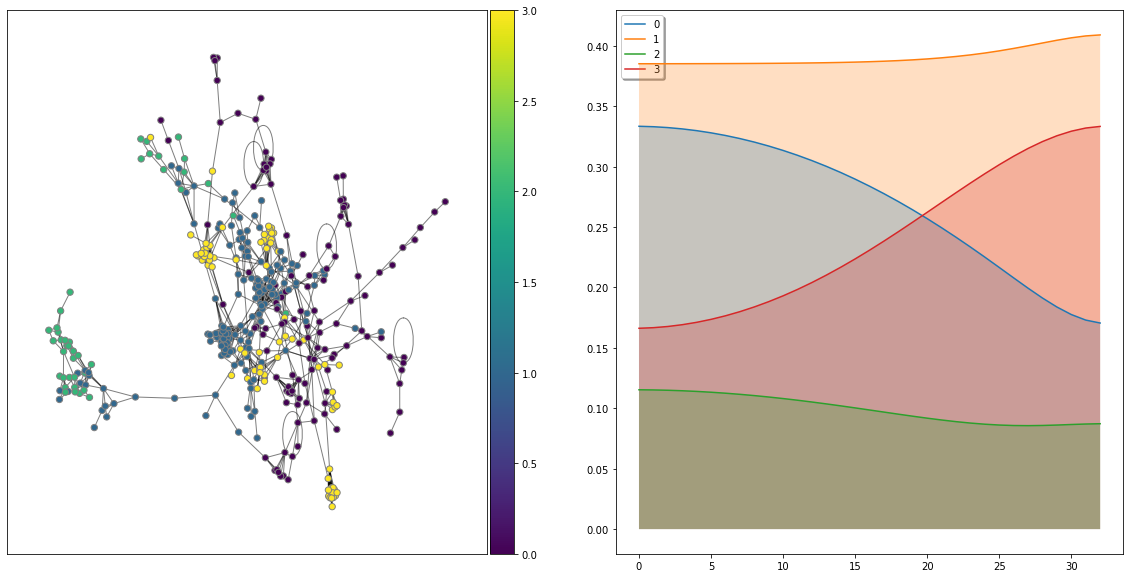

In [114]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_colours(G):
    nodelist = list(G.nodes)
    colours = [G.nodes[n]["target"] for n in nodelist]
    return colours
def get_labels(G):
    nodelist = list(G.nodes)
    labels = {}
    for n in nodelist:
        labels[n] = G.nodes[n]["target"]
    return labels
def get_legend(G):
    nodelist = list(G.nodes)
    colours = [G.nodes[n]["target"] for n in nodelist]
    labels = np.unique(colours).tolist()
    
    return labels
    
g_sample = graphlist[np.random.randint(0, len(graphlist))]
pos = nx.spring_layout(g_sample, k = 0.1, iterations = 100)


fig, (ax1, ax2)  = plt.subplots(ncols = 2, figsize = (20,10))

im = nx.draw_networkx_nodes(g_sample,pos, node_color = get_colours(g_sample), node_size = 40, ax = ax1, edgecolors = "grey")
# nx.draw_networkx_labels(g_sample,pos, get_labels(g_sample), ax = ax1)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax = cax)

nx.draw_networkx_edges(g_sample,pos, node_size = 40, ax = ax1, alpha = 0.5)

ax2 = calculate_probability_by_degree(g_sample, ax2)


[1, 2, 0, 3]
[0, 1, 2, 3]
37
[28177, 28104, 27979, 28113, 28161, 28245, 28111, 27986, 28040, 28216]


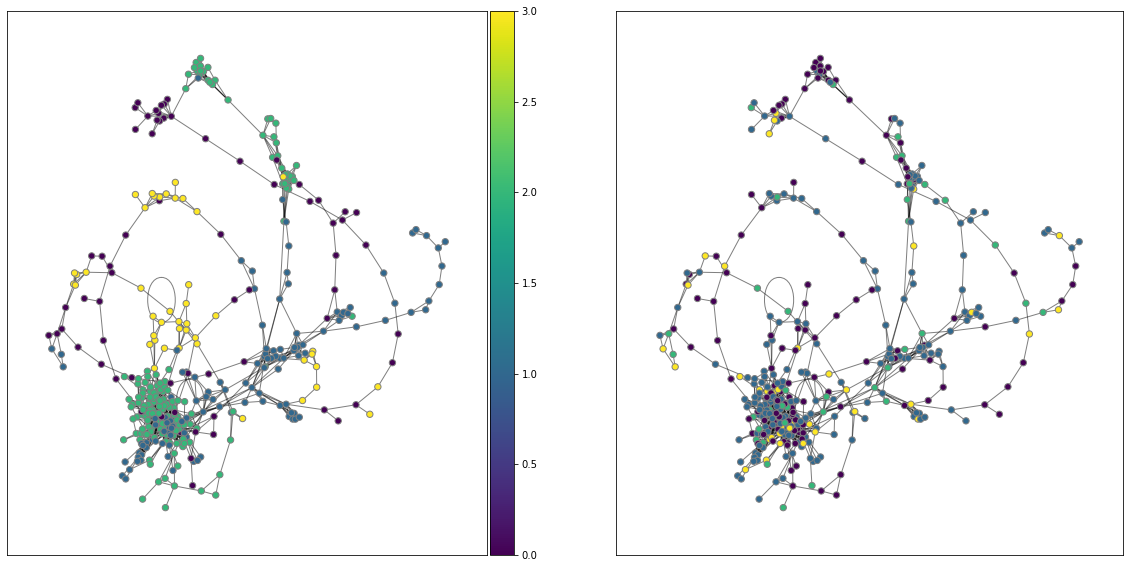

In [141]:
import random
def strip_data(G):
    nodelist = list(G.nodes)
    
    for n in nodelist:
        node = G.nodes[n]
        for k in list(node.keys()):
            del G.nodes[n][k]
    return G


def assign_class_on_prob(topology, n, probability, class_only = False):
    
    # nodes_with_classes = []
    
    # for n in node_selection:
    degree = topology.degree(n)
    class_probs = probability[degree-1, :]
    class_dict = {}
    for i, c in enumerate(class_probs.tolist()):
        class_dict[c] = i

    chance = np.random.random()
    problist = sorted(class_probs.tolist(), reverse = True)
    odds = problist.copy()
    for i, p in enumerate(problist):
        odds[i] += np.sum(problist[:i])

    for i, o in enumerate([0.] + odds[:-1]):
        original_prob = problist[i]

        cla = class_dict[original_prob]

        # print(f"\nchance {chance}\nlower {o}\nupper {odds[i]}\nodds {[0.] + odds[:-1]}")

        if chance >= o and chance <= odds[i]:
            topology.nodes[n]["target"] = cla
            # nodes_with_classes.append(n)
            # print("found one")
            break
    if class_only:
        return topology.nodes[n]["target"]
    return topology

def randomly_propagate(G, k = 10):
    
    probability = calculate_probability_by_degree(G)
    
    topology = strip_data(G.copy())
    
    nodelist = list(G.nodes)
    
    node_selection = []
    while len(node_selection) < k:
        node = random.sample(nodelist, 1)[0]

        nn = list(topology.neighbors(node))
        
        nnns = []
        for inn in nn:
            nnns += list(topology.neighbors(inn))
        
        failed = False
        for existing in node_selection:
            if existing in nnns:
                failed = True
        
        if not failed:
            node_selection.append(node)
    
    
    node_selection = random.sample(nodelist, k)
    print(node_selection)
    
    nodes_with_classes = node_selection.copy()
    
    # Initial class assignment on randomly selected nodes
    for n in node_selection:
        topology = assign_class_on_prob(topology, n, probability)
    
    while sorted(nodes_with_classes) != sorted(nodelist):
    
        for n in nodes_with_classes:
            node_class = topology.nodes[n]["target"]
            neighbours = list(topology.neighbors(n))
            
            for nn in neighbours:
                
                if "target" in topology.nodes[nn]:
                    continue
                
                predicted_class = assign_class_on_prob(topology, n, probability, class_only = True)
                
                if predicted_class != node_class:
                    pass
                else:
                    topology.nodes[nn]["target"] = predicted_class
                    nodes_with_classes.append(nn)
    
    return topology
    
        
#         degree = topology.degree(n)
#         class_probs = probability[degree, :]
#         class_dict = {}
#         for i, c in enumerate(class_probs.tolist()):
#             class_dict[c] = i
        
#         chance = np.random.random()
#         problist = sorted(class_probs.tolist(), reverse = True)
#         odds = problist.copy()
#         for i, p in enumerate(problist):
#             odds[i] += np.sum(problist[:i])
        
#         for i, o in enumerate([0.] + odds[:-1]):
#             original_prob = problist[i]
            
#             cla = class_dict[original_prob]
            
#             # print(f"\nchance {chance}\nlower {o}\nupper {odds[i]}\nodds {[0.] + odds[:-1]}")
            
#             if chance >= o and chance <= odds[i]:
#                 topology.nodes[n]["target"] = cla
#                 # nodes_with_classes.append(n)
#                 # print("found one")
#                 break
    
    # for n in nodes_with_classes:
    
true = graphlist[np.random.randint(0, len(graphlist))]
pred = randomly_propagate(true)


pos = nx.spring_layout(true, k = 0.1, iterations = 100)


fig, (ax1, ax2)  = plt.subplots(ncols = 2, figsize = (20,10))

im = nx.draw_networkx_nodes(true, pos, node_color = get_colours(true), node_size = 40, ax = ax1, edgecolors = "grey")
nx.draw_networkx_edges(true, pos, node_size = 40, ax = ax1, alpha = 0.5)
# nx.draw_networkx_labels(g_sample,pos, get_labels(g_sample), ax = ax1)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax = cax)

im = nx.draw_networkx_nodes(pred, pos, node_color = get_colours(pred), node_size = 40, ax = ax2, edgecolors = "grey")
nx.draw_networkx_edges(pred, pos, node_size = 40, ax = ax2, alpha = 0.5)

# ax2 = calculate_probability_by_degree(g_sample, ax2)
    
    
    # print(list(topology.nodes(data=True)))
    
